In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from transformers import XLNetConfig, XLNetTokenizer, XLNetForSequenceClassification, XLNetModel
from datasets import Dataset
import evaluate
from tqdm import tqdm, trange
import pandas as pd
import numpy as np
import os
from torch import optim
from transformers import XLNetForSequenceClassification, AdamW
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch.nn.utils.rnn import pack_sequence
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

#TRAIN LOADER

data = pd.read_csv(r'..\OLID_Tain.txt', sep='\t',
                   names=['id', 'sentence', 'label1', 'label2', 'label3'])  #Francesco esecution
#train_data = pd.read_csv(r'/content/OLID_Tain_ATUSER_URL_EmojiRemoved_Pedro.txt', delimiter='\t', skiprows=1, names=['id', 'sentence', 'label1', 'label2', 'label3']) # Nebos line

data = data.drop(axis=1, labels=['id', 'label2', 'label3'])
data = data.drop(axis=0, index=0)

# checking how many pos and neg reviews
review_counts = data['label1'].value_counts()
print(f'Count of reviews by sentiment: {review_counts}')

for index, row in data.iterrows():
    if row['label1'] == 'OFF':
        data.at[index, 'label1'] = 0  # for the OFF tweets
    else:
        data.at[index, 'label1'] = 1  # for the NOT tweets

# Checking how many pos and neg reviews
review_counts = data['label1'].value_counts()
print(f'Count of reviews by sentiment: {review_counts}')

nltk.download('punkt')
data['tokens'] = data['sentence'].apply(word_tokenize)

# Create a vocabulary and map tokens to indices
vocab = {word: idx for idx, word in enumerate(set(word for sentence in data['tokens'] for word in sentence), 1)}
data['indexed'] = data['tokens'].apply(lambda x: [vocab[word] for word in x])

# Pad sequences to a maximum length
max_len = max(len(sentence) for sentence in data['indexed'])
data['padded'] = data['indexed'].apply(lambda x: x + [0] * (max_len - len(x)))

# Convert to tensors and split dataset
features = torch.tensor(data['padded'].tolist())
labels = torch.tensor(data['label1'].tolist())

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2,
                                                                            random_state=42)

train_data = TensorDataset(train_features, train_labels)
test_data = TensorDataset(test_features, test_labels)
train_loader = DataLoader(train_data, batch_size=10)
test_loader = DataLoader(test_data, batch_size=10)

tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')




using cuda
Count of reviews by sentiment: label1
NOT    8840
OFF    4400
Name: count, dtype: int64
Count of reviews by sentiment: label1
1    8840
0    4400
Name: count, dtype: int64


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\unm30\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\unm30\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [105]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

class GRU(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size, dropout_rate=0.3, num_layers=3):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # *2 for bidirectional

    def forward(self, input):
        embedded = self.embedding(input)
        output, hidden = self.gru(embedded)
        output = self.dropout(output)
        output = self.fc(output[:, -1, :])  # select the last timestep's output
        return output

class LSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size, dropout_rate=0.3, num_layers=3):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # *2 for bidirectional

    def forward(self, input):
        embedded = self.embedding(input)
        output, (hidden, cell) = self.lstm(embedded)
        output = self.dropout(output)
        output = self.fc(output[:, -1, :])  # select the last timestep's output
        return output

class CNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size, dropout_rate=0.3):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.conv1 = nn.Conv2d(1, 100, (3, hidden_size))
        self.conv2 = nn.Conv2d(100, 100, (4, 1))  # change kernel size
        self.conv3 = nn.Conv2d(100, 100, (5, 1))  # change kernel size
        self.conv4 = nn.Conv2d(100, 100, (3, 1))  # change kernel size
        self.conv5 = nn.Conv2d(100, 100, (4, 1))  # change kernel size
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(500, output_size)

    def forward(self, input):
        embedded = self.embedding(input).unsqueeze(1)
        conv1_out = torch.relu(self.conv1(embedded))
        conv2_out = torch.relu(self.conv2(conv1_out))
        conv3_out = torch.relu(self.conv3(conv2_out))
        conv4_out = torch.relu(self.conv4(conv3_out))
        conv5_out = torch.relu(self.conv5(conv4_out))
        pooled1 = torch.max(conv1_out, dim=2)[0].squeeze(2)
        pooled2 = torch.max(conv2_out, dim=2)[0].squeeze(2)
        pooled3 = torch.max(conv3_out, dim=2)[0].squeeze(2)
        pooled4 = torch.max(conv4_out, dim=2)[0].squeeze(2)
        pooled5 = torch.max(conv5_out, dim=2)[0].squeeze(2)
        concat = torch.cat((pooled1, pooled2, pooled3, pooled4, pooled5), dim=1)
        dropout_out = self.dropout(concat)
        output = self.fc(dropout_out)
        return output

class EnsembleModel(nn.Module):
    def __init__(self, gru, lstm, cnn, xlnet, combined_dim, output_dim):
        super(EnsembleModel, self).__init__()
        self.gru = gru
        self.lstm = lstm
        self.cnn = cnn
        self.xlnet = xlnet
        self.aggregator = nn.Linear(combined_dim, output_dim)  # Correct input size

    def forward(self, input, xlnet_input):
        gru_output = self.gru(input)
        lstm_output = self.lstm(input)
        cnn_output = self.cnn(input)

        # XLNet processing
        xlnet_outputs = self.xlnet(**xlnet_input)
        xlnet_output = xlnet_outputs.logits

        # Ensure dimensions are correct before concatenation
        xlnet_output = xlnet_output.squeeze(1)
        
        
        # Concatenate all outputs
        combined = torch.cat((gru_output, lstm_output, cnn_output, xlnet_output), dim=1)
        print(f'Combined output shape: {combined.shape}')
        
        output = self.aggregator(combined)
        return output

C:\Users\unm30\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [106]:
VOCAB_SIZE = len(vocab)
vocab_size = VOCAB_SIZE + 1
hidden_dim = 128
output_dim = 2

gru_model = GRU(vocab_size, hidden_dim, output_dim, dropout_rate=0.3).to(device)
lstm_model = LSTM(vocab_size, hidden_dim, output_dim, dropout_rate=0.3).to(device)
cnn_model = CNN(vocab_size, hidden_dim, output_dim, dropout_rate=0.3).to(device)
xlnet_model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=output_dim).to(device)
output_dim_each_model = 2
num_models = 4

# Correctly calculate the combined_dim
combined_dim = output_dim_each_model * num_models

# Create the ensemble model with the correct combined_dim
ensemble_model = EnsembleModel(gru_model, lstm_model, cnn_model, xlnet_model, combined_dim, output_dim).to(device)

# Define optimizers and loss function
optimizer = optim.Adam(ensemble_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Create inverse vocab (itos) from vocab
itos = {index: word for word, index in vocab.items()}

# Function to decode tensor texts to list of strings
def decode_texts(texts_tensor, itos, pad_token='[PAD]'):
    decoded_texts = []
    for text in texts_tensor:
        decoded_texts.append(' '.join([itos.get(token.item(), pad_token) for token in text]))
    return decoded_texts



C:\Users\unm30\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [104]:
def train_model(model, train_loader, optimizer, loss_fn, epochs=1, max_length=128):
    model.train()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    for epoch in range(epochs):
        train_loss = 0.0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # XLNet tokenization
            decoded_texts = decode_texts(texts, itos)
            inputs = tokenizer(decoded_texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
            inputs = {key: val.to(device) for key, val in inputs.items()}

            predictions = model(texts, inputs)
            loss = loss_fn(predictions, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * texts.size(0)
        
        avg_loss = train_loss / len(train_loader.dataset)
        scheduler.step()
        print(f'Epoch {epoch+1}, Loss: {avg_loss}')

# Assuming train_loader is already defined
# Train the ensemble model
train_model(ensemble_model, train_loader, optimizer, loss_fn, epochs=10)



def generate_ensemble_outputs(models, data_loader):
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for texts, labels in data_loader:
            texts = texts.to(device)
            outputs = []
            for model in models:
                if isinstance(model, XLNetForSequenceClassification):
                    output = model(texts).logits
                else:
                    output = model(texts)
                outputs.append(output)
            outputs = torch.cat(outputs, dim=1)
            all_outputs.append(outputs)
            all_labels.append(labels)
    return torch.cat(all_outputs), torch.cat(all_labels)

train_outputs, train_labels = generate_ensemble_outputs([model1, model2, model3, model4], train_loader)
test_outputs, test_labels = generate_ensemble_outputs([model1, model2, model3, model4], test_loader)

# Train the dense aggregator
aggregator = DenseAggregator(input_dim=train_outputs.size(1), hidden_dim=64, output_dim=output_dim)
aggregator = aggregator.to(device)
optimizer_agg = optim.Adam(aggregator.parameters(), lr=0.001)
loss_fn_agg = nn.CrossEntropyLoss()

GRU output shape: torch.Size([10, 2])
LSTM output shape: torch.Size([10, 2])
CNN output shape: torch.Size([10, 2])
XLNet output shape: torch.Size([10, 2])
Combined output shape: torch.Size([10, 8])
GRU output shape: torch.Size([10, 2])
LSTM output shape: torch.Size([10, 2])
CNN output shape: torch.Size([10, 2])
XLNet output shape: torch.Size([10, 2])
Combined output shape: torch.Size([10, 8])
GRU output shape: torch.Size([10, 2])
LSTM output shape: torch.Size([10, 2])
CNN output shape: torch.Size([10, 2])
XLNet output shape: torch.Size([10, 2])
Combined output shape: torch.Size([10, 8])
GRU output shape: torch.Size([10, 2])
LSTM output shape: torch.Size([10, 2])
CNN output shape: torch.Size([10, 2])
XLNet output shape: torch.Size([10, 2])
Combined output shape: torch.Size([10, 8])
GRU output shape: torch.Size([10, 2])
LSTM output shape: torch.Size([10, 2])
CNN output shape: torch.Size([10, 2])
XLNet output shape: torch.Size([10, 2])
Combined output shape: torch.Size([10, 8])
GRU output

KeyboardInterrupt: 

In [ ]:
train_outputs, train_labels = generate_ensemble_outputs([model1, model2, model3, model4], train_loader)
test_outputs, test_labels = generate_ensemble_outputs([model1, model2, model3, model4], val_loader)

# Train the dense aggregator
aggregator = DenseAggregator(input_dim=train_outputs.size(1), hidden_dim=64, output_dim=output_dim)
aggregator = aggregator.to(device)
optimizer_agg = optim.Adam(aggregator.parameters(), lr=0.001)
loss_fn_agg = nn.CrossEntropyLoss()

In [71]:
def generate_ensemble_outputs(models, data_loader):
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for texts, labels in data_loader:
            texts = texts.to(device)
            outputs = [model(texts) for model in models]
            outputs = torch.cat(outputs, dim=1)
            all_outputs.append(outputs)
            all_labels.append(labels)
    return torch.cat(all_outputs), torch.cat(all_labels)

train_outputs, train_labels = generate_ensemble_outputs([model1, model2, model3, model4], train_loader)
test_outputs, test_labels = generate_ensemble_outputs([model1, model2, model3, model4], val_loader)

# Train the dense aggregator
aggregator = DenseAggregator(input_dim=train_outputs.size(1), hidden_dim=64, output_dim=output_dim)
aggregator = aggregator.to(device)
optimizer_agg = optim.Adam(aggregator.parameters(), lr=0.001)
loss_fn_agg = nn.CrossEntropyLoss()

def train_aggregator(model, data, labels, optimizer, loss_fn, epochs=50):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

train_aggregator(aggregator, train_outputs, train_labels.to(device), optimizer_agg, loss_fn_agg)

def ensemble_predict_with_aggregator(models, aggregator, inputs):
    with torch.no_grad():
        outputs = [model(inputs) for model in models]
        outputs = torch.cat(outputs, dim=1)
        final_output = aggregator(outputs)
        probs = torch.nn.functional.softmax(final_output, dim=1)
        predicted = torch.argmax(final_output, dim=1)
    return predicted, probs

# Evaluate the ensemble with the aggregator
all_labels = []
all_preds = []

with torch.no_grad():
    for texts, labels in val_loader:
        texts, labels = texts.to(device), labels.to(device)
        predicted, probs = ensemble_predict_with_aggregator([model1, model2, model3, model4], aggregator, texts)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Ensemble with Aggregator Accuracy: {accuracy}')

In [72]:


train_outputs, train_labels = generate_ensemble_outputs([model1, model2, model3], train_loader)
test_outputs, test_labels = generate_ensemble_outputs([model1, model2, model3], test_loader)

# Train the dense aggregator
aggregator = DenseAggregator(input_dim=train_outputs.size(1), hidden_dim=64, output_dim=output_dim)
aggregator = aggregator.to(device)
optimizer_agg = optim.Adam(aggregator.parameters(), lr=0.001)
loss_fn_agg = nn.CrossEntropyLoss()


In [74]:
def train_aggregator(model, data, labels, optimizer, loss_fn, epochs=50):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')


train_aggregator(aggregator, train_outputs, train_labels.to(device), optimizer_agg, loss_fn_agg)


def ensemble_predict_with_aggregator(models, aggregator, inputs):
    with torch.no_grad():
        outputs = [model(inputs) for model in models]
        outputs = torch.cat(outputs, dim=1)
        final_output = aggregator(outputs)
        probs = torch.nn.functional.softmax(final_output, dim=1)
        predicted = torch.argmax(final_output, dim=1)
    return predicted, probs


# Evaluate the ensemble with the aggregator
all_labels = []
all_preds = []

with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        predicted, probs = ensemble_predict_with_aggregator([model1, model2, model3], aggregator, texts)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Ensemble with Aggregator Accuracy: {accuracy}')

Epoch 1, Loss: 0.04854065179824829
Epoch 2, Loss: 0.047369640320539474
Epoch 3, Loss: 0.046259522438049316
Epoch 4, Loss: 0.04520576074719429
Epoch 5, Loss: 0.044204145669937134
Epoch 6, Loss: 0.04325119033455849
Epoch 7, Loss: 0.04234326630830765
Epoch 8, Loss: 0.04147724807262421
Epoch 9, Loss: 0.04065024107694626
Epoch 10, Loss: 0.03985975310206413
Epoch 11, Loss: 0.039103325456380844
Epoch 12, Loss: 0.03837889805436134
Epoch 13, Loss: 0.03768442943692207
Epoch 14, Loss: 0.03701808303594589
Epoch 15, Loss: 0.03637812286615372
Epoch 16, Loss: 0.03576292470097542
Epoch 17, Loss: 0.0351710170507431
Epoch 18, Loss: 0.03460109978914261
Epoch 19, Loss: 0.03405195102095604
Epoch 20, Loss: 0.03352232649922371
Epoch 21, Loss: 0.03301120176911354
Epoch 22, Loss: 0.03251756727695465
Epoch 23, Loss: 0.032040584832429886
Epoch 24, Loss: 0.03157941251993179
Epoch 25, Loss: 0.031133167445659637
Epoch 26, Loss: 0.03070145659148693
Epoch 27, Loss: 0.030283544212579727
Epoch 28, Loss: 0.0298785734921

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.49      0.55       915
           1       0.76      0.86      0.81      1733

    accuracy                           0.73      2648
   macro avg       0.70      0.67      0.68      2648
weighted avg       0.72      0.73      0.72      2648

Confusion Matrix
[[ 445  470]
 [ 248 1485]]
ROC AUC Score:
0.7418409593269828


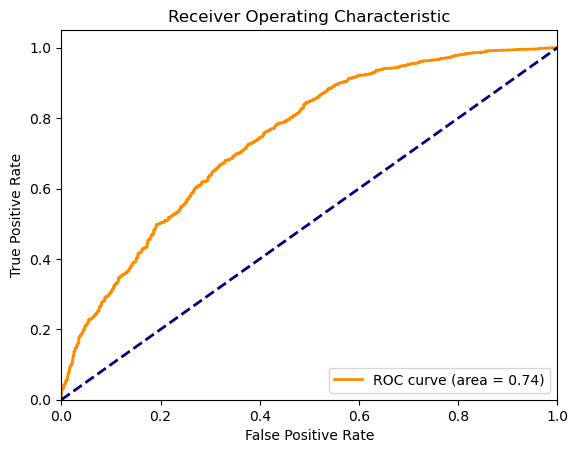

In [75]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def evaluate_ensemble_with_aggregator(models, aggregator, test_loader):
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            predicted, probs = ensemble_predict_with_aggregator(models, aggregator, texts)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    # Calculate metrics
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))
    print("Confusion Matrix")
    print(confusion_matrix(all_labels, all_preds))

    # ROC AUC and ROC Curve are applicable only for binary classification
    if output_dim == 2:
        roc_auc = roc_auc_score(all_labels, all_probs)
        fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

        print("ROC AUC Score:")
        print(roc_auc)

        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

evaluate_ensemble_with_aggregator([model1, model2, model3], aggregator, test_loader)

In [ ]:
class BertGRUNetwork(nn.Module):
    def __init__(self, gru_hidden_dim, gru_layers):
        super(BertGRUNetwork, self).__init__()
        # Load the BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        
        # GRU setup
        self.gru = nn.GRU(self.bert.config.hidden_size, gru_hidden_dim, num_layers=gru_layers, batch_first=True)
        self.classifier = nn.Linear(gru_hidden_dim, 2)  # Adjust the output features according to your number of classes

    def forward(self, input_ids, attention_mask):
        # BERT layer
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # We use last hidden state
        gru_output, _ = self.gru(bert_output.last_hidden_state)
        
        # Use only the output of the last GRU output
        logits = self.classifier(gru_output[:, -1, :])
        return logits

# Define device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertGRUNetwork(gru_hidden_dim=256, gru_layers=1)
model.to(device)

In [ ]:
from transformers import BertTokenizer

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Testing loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        texts, labels = data
        labels = labels.to(device)

        # Tokenize texts
        inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)

        # Forward pass
        outputs = model(**inputs)
        _, predicted = torch.max(outputs, 1)

        # Update correct
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test dataset: {accuracy:.2f}%')